<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Boston_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 3us/step


In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
train_targets[0]

15.2

Now our data is ready to be fed into a neural network.

In [5]:
!rm -f vaes_net.py
!wget "https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py"

--2020-03-20 15:20:07--  https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10514 (10K) [text/plain]
Saving to: ‘vaes_net.py’

vaes_net.py         100%[===================>]  10.27K  --.-KB/s    in 0s      

2020-03-20 15:20:07 (120 MB/s) - ‘vaes_net.py’ saved [10514/10514]



In [0]:
labels = ['per capita crime rate by town', 
          'proportion of residential land zoned for lots over 25,000 sq.ft.',
          'proportion of non-retail business acres per town',
          'Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
          'nitric oxides concentration (parts per 10 million)',
          'average number of rooms per dwelling',
          'proportion of owner-occupied units built prior to 1940',
          'weighted distances to five Boston employment centres',
          'index of accessibility to radial highways',
          'full-value property-tax rate per $10,000',
          'pupil-teacher ratio by town',
          '1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
          '% lower status of the population',
          'Median value of owner-occupied homes in $1000\'s']

In [0]:
import numpy as np

In [8]:
train_data.shape

(404, 13)

In [9]:
train_targets.shape

(404,)

In [0]:
train_data = np.concatenate([train_data, train_targets.reshape((len(train_targets),1))], axis = 1)

In [11]:
train_data.shape

(404, 14)

In [0]:
test_data = np.concatenate([test_data, test_targets.reshape((len(test_targets),1))], axis = 1)

In [13]:
test_data.shape

(102, 14)

In [14]:
data = np.concatenate([train_data,test_data],axis=0)
data.shape

(506, 14)

In [15]:
import pandas as pd

data = pd.DataFrame(data, columns = labels)
data

,per capita crime rate by town,"proportion of residential land zoned for lots over 25,000 sq.ft.",proportion of non-retail business acres per town,Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),nitric oxides concentration (parts per 10 million),average number of rooms per dwelling,proportion of owner-occupied units built prior to 1940,weighted distances to five Boston employment centres,index of accessibility to radial highways,"full-value property-tax rate per $10,000",pupil-teacher ratio by town,1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,% lower status of the population,Median value of owner-occupied homes in $1000's
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
502,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,394.92,6.78,24.1
503,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
504,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7


In [16]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=100, random_state=2)
qt_trans.fit(data[:1000])
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels

qt

,per capita crime rate by town,"proportion of residential land zoned for lots over 25,000 sq.ft.",proportion of non-retail business acres per town,Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),nitric oxides concentration (parts per 10 million),average number of rooms per dwelling,proportion of owner-occupied units built prior to 1940,weighted distances to five Boston employment centres,index of accessibility to radial highways,"full-value property-tax rate per $10,000",pupil-teacher ratio by town,1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,% lower status of the population,Median value of owner-occupied homes in $1000's
0,0.672697,0.000000,0.449495,0.0,0.515152,0.448171,0.697044,0.621089,0.272727,0.414141,0.939394,1.000000,0.827862,0.195463
1,0.036570,0.974747,0.041375,0.0,0.081374,0.951558,0.036750,0.851160,0.060606,0.525253,0.065657,0.697053,0.025237,0.946027
2,0.788430,0.000000,0.757576,0.0,0.757576,0.026673,1.000000,0.019254,1.000000,0.863636,0.752525,0.250689,0.032351,1.000000
3,0.103654,0.000000,0.257576,0.0,0.434343,0.376083,0.173677,0.826611,0.489899,0.075758,0.752525,1.000000,0.318333,0.494949
4,0.751397,0.000000,0.757576,0.0,0.893939,0.600322,0.636364,0.388883,1.000000,0.863636,0.752525,0.497545,0.660653,0.279461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.745066,0.000000,0.757576,1.0,0.919192,1.000000,0.554187,0.184934,1.000000,0.863636,0.752525,0.174718,0.141414,0.545455
502,0.241375,0.000000,0.595960,0.0,0.156566,0.546738,0.008417,0.658274,0.489899,0.590909,0.474747,0.665699,0.236525,0.696970
503,0.700953,0.000000,0.919192,1.0,0.686869,0.961454,0.880556,0.231891,0.489899,0.641414,0.065657,0.433674,0.001660,1.000000
504,0.550970,0.000000,0.323232,1.0,0.404040,0.855858,0.638413,0.452036,0.717172,0.414141,0.267677,0.505036,0.416125,0.772716


In [0]:
x_train = qt[:404]
x_test = qt[404:]

n_features = qt.shape[1]

In [0]:
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

In [0]:
import vaes_net as vnn
import importlib

In [20]:
from tensorflow import set_random_seed
from numpy.random import seed

importlib.reload(vnn)
seed(42)
set_random_seed(42)

vae = vnn.make_vae(full_data=qt.iloc[:,:n_features],  
    img_shape = (n_features+1, ),
    latent_dim = 1, 
    dense_width = 4096,
    l2_penalty=0.0,
    l1_penalty=0.0,
    encoder_dropout_rate=0.3,
    decoder_dropout_rate=0.3,
    input_aug = 0,
    hidden_n = 2,
    optimizer = keras.optimizers.Adam(lr=0.001),
    plot_every_n = 50,
    plot_types_args = {'n_type': 60, 'each_hight' : 20, 
                                  'approx_width': 400, 
                                  'frac_width': 0.55, 
                                  'n_activity':  n_features,  
                                  'lowest_percentile': 0.05, 
                                  'highest_percentile' : 99.5, 
                                  'figsize': (10, 8),
                                  'cmap': 'viridis', 
                                  'n_xlabels':13, 
                                  'spacing': -0.001, 
                                  'hist_size': 0.2, 
                                  'scaler': True})  


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 1)


In [0]:
epochs = 1500
batch_size = 128

Train on 404 samples, validate on 102 samples
Epoch 1/1500
128/404 [========>.....................] - ETA: 6s - loss: 0.3181

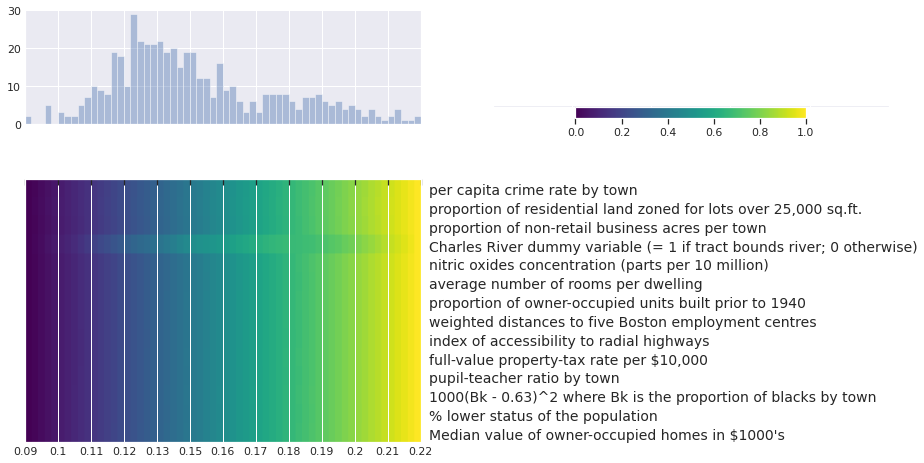

404/404 [==============================] - 5s 11ms/sample - loss: 32.6760 - val_loss: 0.2029
Epoch 2/1500
404/404 [==============================] - 0s 176us/sample - loss: 0.2431 - val_loss: 0.2463
Epoch 3/1500
404/404 [==============================] - 0s 166us/sample - loss: 0.1768 - val_loss: 0.0850
Epoch 4/1500
404/404 [==============================] - 0s 170us/sample - loss: 0.1292 - val_loss: 0.1626
Epoch 5/1500
404/404 [==============================] - 0s 171us/sample - loss: 0.1310 - val_loss: 0.1093
Epoch 6/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.1169 - val_loss: 0.1087
Epoch 7/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.1127 - val_loss: 0.0848
Epoch 8/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0981 - val_loss: 0.0814
Epoch 9/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0928 - val_loss: 0.0918
Epoch 10/1500
404/404 [==============================] - 0s

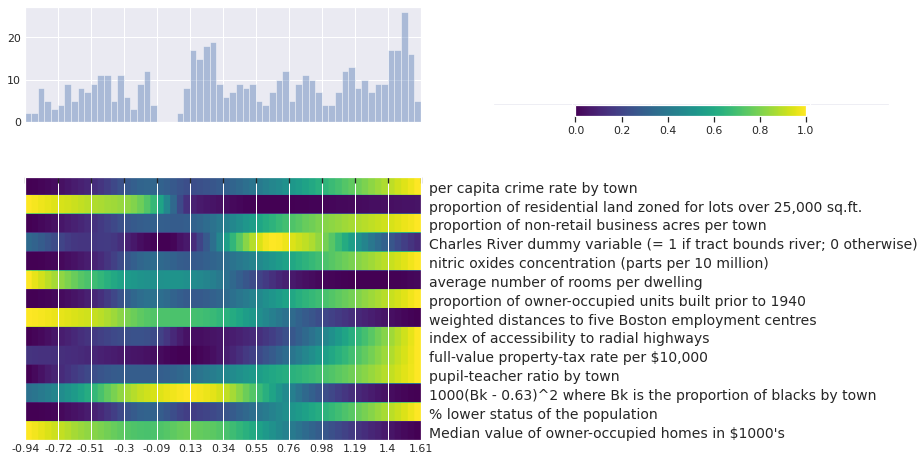

404/404 [==============================] - 1s 3ms/sample - loss: 0.0435 - val_loss: 0.0421
Epoch 52/1500
404/404 [==============================] - 0s 167us/sample - loss: 0.0428 - val_loss: 0.0422
Epoch 53/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0434 - val_loss: 0.0417
Epoch 54/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0428 - val_loss: 0.0408
Epoch 55/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0424 - val_loss: 0.0417
Epoch 56/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0426 - val_loss: 0.0409
Epoch 57/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0421 - val_loss: 0.0424
Epoch 58/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0426 - val_loss: 0.0405
Epoch 59/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0422 - val_loss: 0.0412
Epoch 60/1500
404/404 [==============================

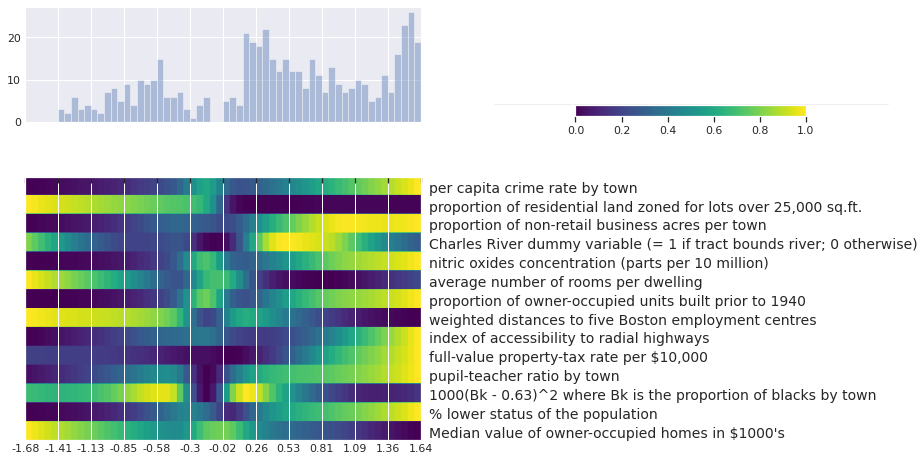

404/404 [==============================] - 1s 3ms/sample - loss: 0.0402 - val_loss: 0.0395
Epoch 102/1500
404/404 [==============================] - 0s 180us/sample - loss: 0.0403 - val_loss: 0.0402
Epoch 103/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0404 - val_loss: 0.0404
Epoch 104/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0398 - val_loss: 0.0381
Epoch 105/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0386 - val_loss: 0.0392
Epoch 106/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0393 - val_loss: 0.0407
Epoch 107/1500
404/404 [==============================] - 0s 167us/sample - loss: 0.0396 - val_loss: 0.0387
Epoch 108/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0391 - val_loss: 0.0380
Epoch 109/1500
404/404 [==============================] - 0s 166us/sample - loss: 0.0394 - val_loss: 0.0406
Epoch 110/1500
404/404 [=====================

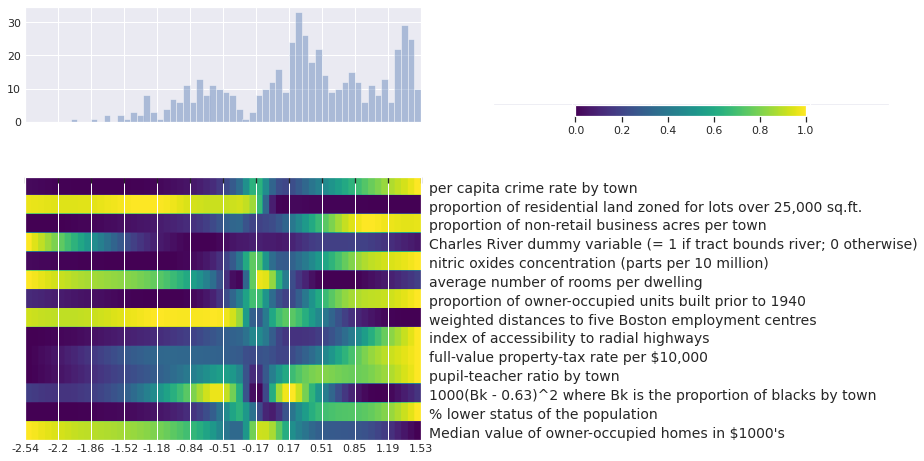

404/404 [==============================] - 1s 3ms/sample - loss: 0.0381 - val_loss: 0.0367
Epoch 152/1500
404/404 [==============================] - 0s 188us/sample - loss: 0.0371 - val_loss: 0.0360
Epoch 153/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0374 - val_loss: 0.0363
Epoch 154/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0368 - val_loss: 0.0354
Epoch 155/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0369 - val_loss: 0.0362
Epoch 156/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0365 - val_loss: 0.0359
Epoch 157/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0369 - val_loss: 0.0364
Epoch 158/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0369 - val_loss: 0.0365
Epoch 159/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0367 - val_loss: 0.0364
Epoch 160/1500
404/404 [=====================

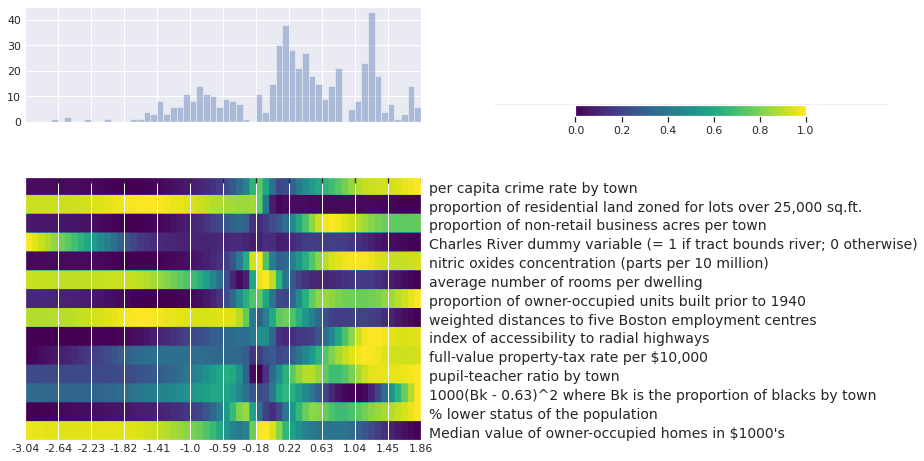

404/404 [==============================] - 1s 3ms/sample - loss: 0.0348 - val_loss: 0.0338
Epoch 202/1500
404/404 [==============================] - 0s 179us/sample - loss: 0.0345 - val_loss: 0.0330
Epoch 203/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0351 - val_loss: 0.0340
Epoch 204/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0354 - val_loss: 0.0346
Epoch 205/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0355 - val_loss: 0.0357
Epoch 206/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0355 - val_loss: 0.0332
Epoch 207/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0345 - val_loss: 0.0329
Epoch 208/1500
404/404 [==============================] - 0s 166us/sample - loss: 0.0345 - val_loss: 0.0348
Epoch 209/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0356 - val_loss: 0.0342
Epoch 210/1500
404/404 [=====================

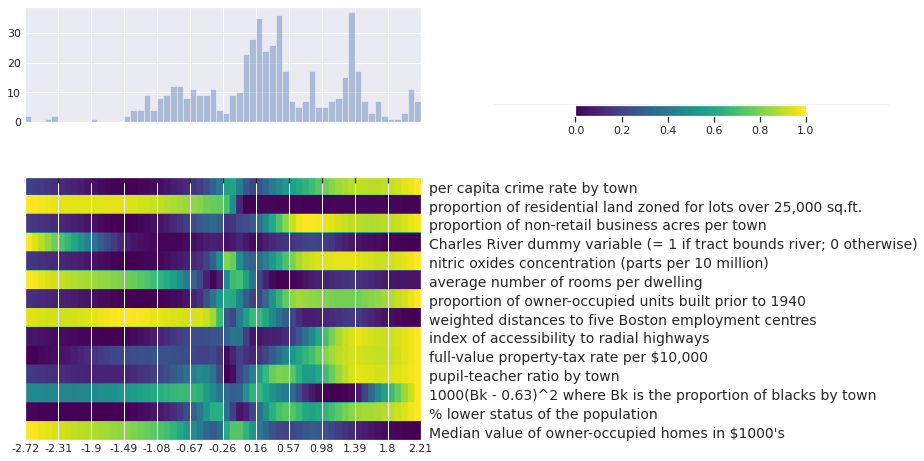

404/404 [==============================] - 1s 3ms/sample - loss: 0.0328 - val_loss: 0.0322
Epoch 252/1500
404/404 [==============================] - 0s 170us/sample - loss: 0.0331 - val_loss: 0.0318
Epoch 253/1500
404/404 [==============================] - 0s 167us/sample - loss: 0.0325 - val_loss: 0.0314
Epoch 254/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0323 - val_loss: 0.0315
Epoch 255/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0321 - val_loss: 0.0311
Epoch 256/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0325 - val_loss: 0.0311
Epoch 257/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0327 - val_loss: 0.0317
Epoch 258/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0325 - val_loss: 0.0314
Epoch 259/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0321 - val_loss: 0.0320
Epoch 260/1500
404/404 [=====================

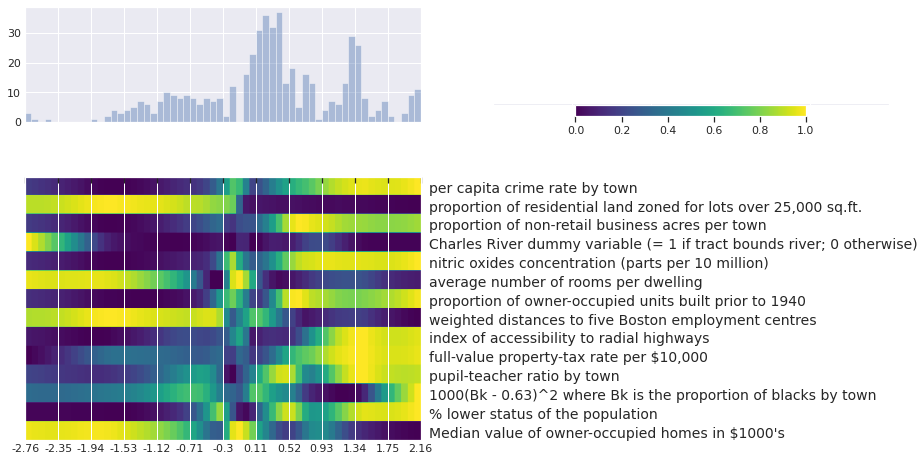

404/404 [==============================] - 1s 3ms/sample - loss: 0.0318 - val_loss: 0.0303
Epoch 302/1500
404/404 [==============================] - 0s 167us/sample - loss: 0.0318 - val_loss: 0.0312
Epoch 303/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0324 - val_loss: 0.0315
Epoch 304/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0318 - val_loss: 0.0300
Epoch 305/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0312 - val_loss: 0.0300
Epoch 306/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0318 - val_loss: 0.0314
Epoch 307/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0314 - val_loss: 0.0304
Epoch 308/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0316 - val_loss: 0.0317
Epoch 309/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0321 - val_loss: 0.0309
Epoch 310/1500
404/404 [=====================

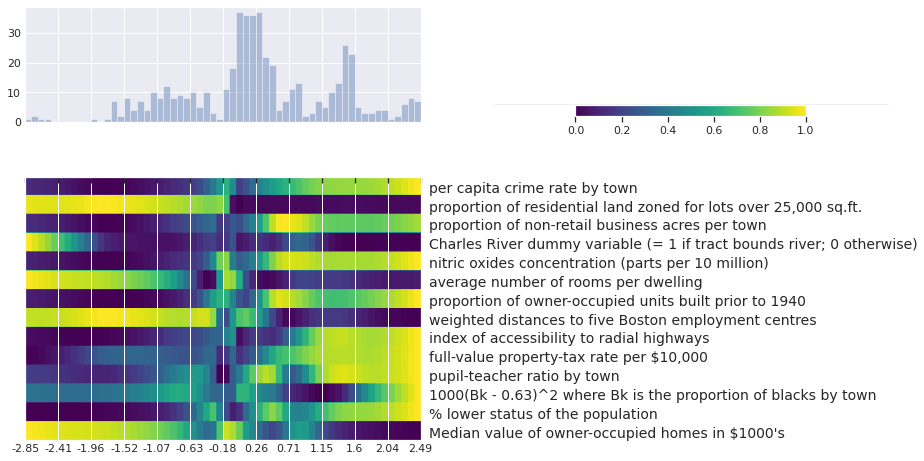

404/404 [==============================] - 1s 3ms/sample - loss: 0.0316 - val_loss: 0.0307
Epoch 352/1500
404/404 [==============================] - 0s 179us/sample - loss: 0.0317 - val_loss: 0.0309
Epoch 353/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0309 - val_loss: 0.0305
Epoch 354/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0315 - val_loss: 0.0295
Epoch 355/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0309 - val_loss: 0.0291
Epoch 356/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0300 - val_loss: 0.0294
Epoch 357/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0300 - val_loss: 0.0299
Epoch 358/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0301 - val_loss: 0.0297
Epoch 359/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0308 - val_loss: 0.0302
Epoch 360/1500
404/404 [=====================

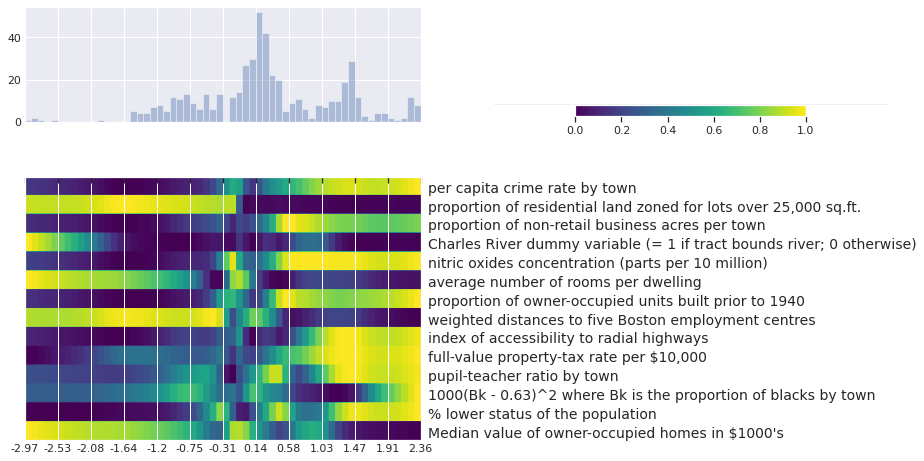

404/404 [==============================] - 1s 3ms/sample - loss: 0.0297 - val_loss: 0.0286
Epoch 402/1500
404/404 [==============================] - 0s 167us/sample - loss: 0.0301 - val_loss: 0.0294
Epoch 403/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0309 - val_loss: 0.0295
Epoch 404/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0308 - val_loss: 0.0292
Epoch 405/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0306 - val_loss: 0.0299
Epoch 406/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0305 - val_loss: 0.0295
Epoch 407/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0303 - val_loss: 0.0306
Epoch 408/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0301 - val_loss: 0.0296
Epoch 409/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0298 - val_loss: 0.0294
Epoch 410/1500
404/404 [=====================

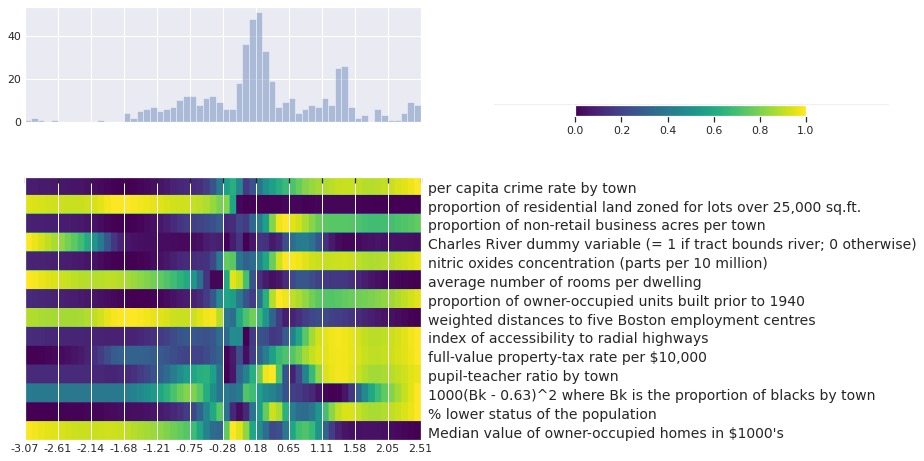

404/404 [==============================] - 1s 3ms/sample - loss: 0.0300 - val_loss: 0.0287
Epoch 452/1500
404/404 [==============================] - 0s 172us/sample - loss: 0.0295 - val_loss: 0.0287
Epoch 453/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0290 - val_loss: 0.0284
Epoch 454/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0287 - val_loss: 0.0287
Epoch 455/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0291 - val_loss: 0.0283
Epoch 456/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0293 - val_loss: 0.0285
Epoch 457/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0292 - val_loss: 0.0287
Epoch 458/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0290 - val_loss: 0.0285
Epoch 459/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0286 - val_loss: 0.0277
Epoch 460/1500
404/404 [=====================

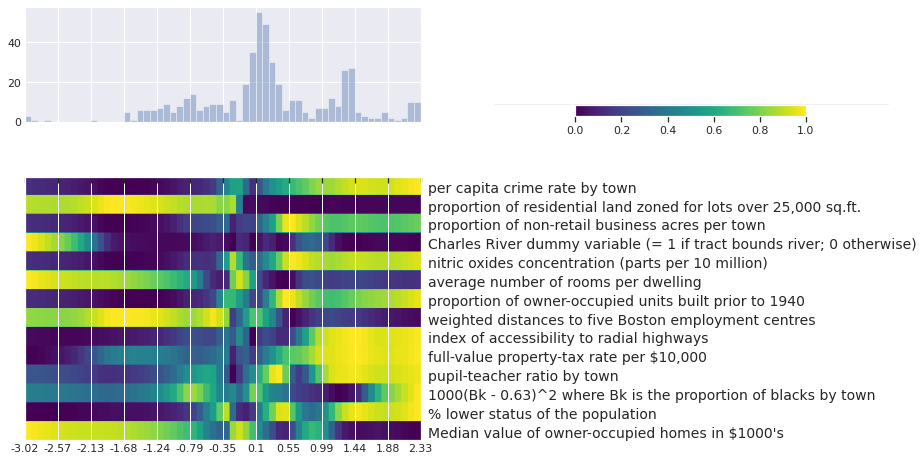

404/404 [==============================] - 1s 3ms/sample - loss: 0.0283 - val_loss: 0.0275
Epoch 502/1500
404/404 [==============================] - 0s 174us/sample - loss: 0.0280 - val_loss: 0.0284
Epoch 503/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0281 - val_loss: 0.0277
Epoch 504/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0279 - val_loss: 0.0280
Epoch 505/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0286 - val_loss: 0.0272
Epoch 506/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0278 - val_loss: 0.0272
Epoch 507/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0285 - val_loss: 0.0268
Epoch 508/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0280 - val_loss: 0.0279
Epoch 509/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0280 - val_loss: 0.0279
Epoch 510/1500
404/404 [=====================

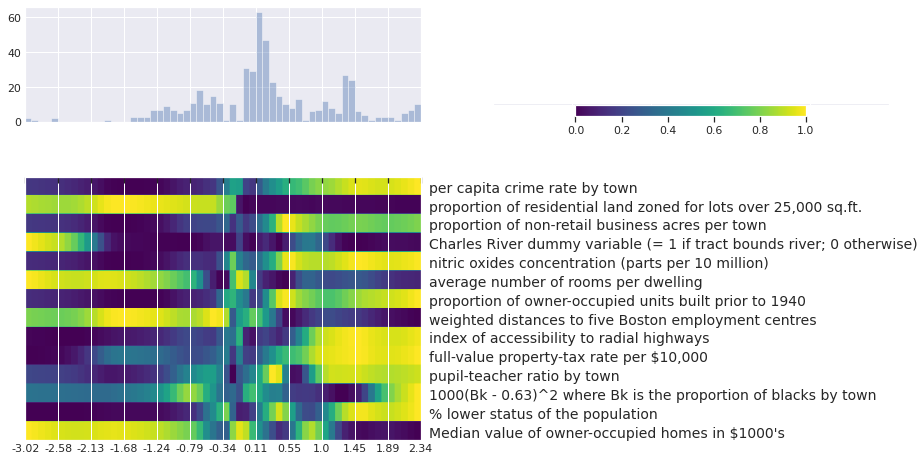

404/404 [==============================] - 1s 3ms/sample - loss: 0.0279 - val_loss: 0.0284
Epoch 552/1500
404/404 [==============================] - 0s 173us/sample - loss: 0.0282 - val_loss: 0.0277
Epoch 553/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0284 - val_loss: 0.0271
Epoch 554/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0279 - val_loss: 0.0270
Epoch 555/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0275 - val_loss: 0.0272
Epoch 556/1500
404/404 [==============================] - 0s 166us/sample - loss: 0.0276 - val_loss: 0.0277
Epoch 557/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0281 - val_loss: 0.0268
Epoch 558/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0281 - val_loss: 0.0281
Epoch 559/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0286 - val_loss: 0.0275
Epoch 560/1500
404/404 [=====================

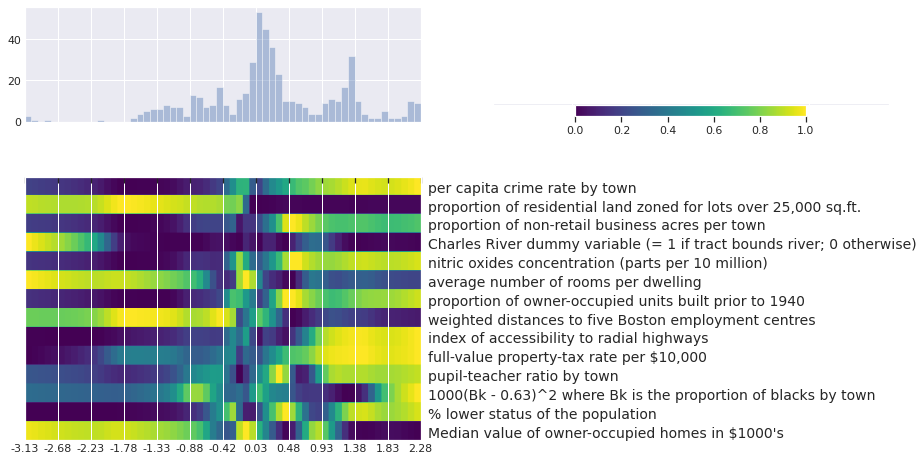

404/404 [==============================] - 1s 3ms/sample - loss: 0.0274 - val_loss: 0.0270
Epoch 602/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0268 - val_loss: 0.0263
Epoch 603/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0269 - val_loss: 0.0272
Epoch 604/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0270 - val_loss: 0.0272
Epoch 605/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0272 - val_loss: 0.0266
Epoch 606/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0272 - val_loss: 0.0266
Epoch 607/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0269 - val_loss: 0.0269
Epoch 608/1500
128/404 [========>.....................] - ETA: 0s - loss: 0.0267
Epoch 00608: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.
404/404 [==============================] - 0s 165us/sample - loss: 0.0272 - val_loss: 0.0271
Epoch 

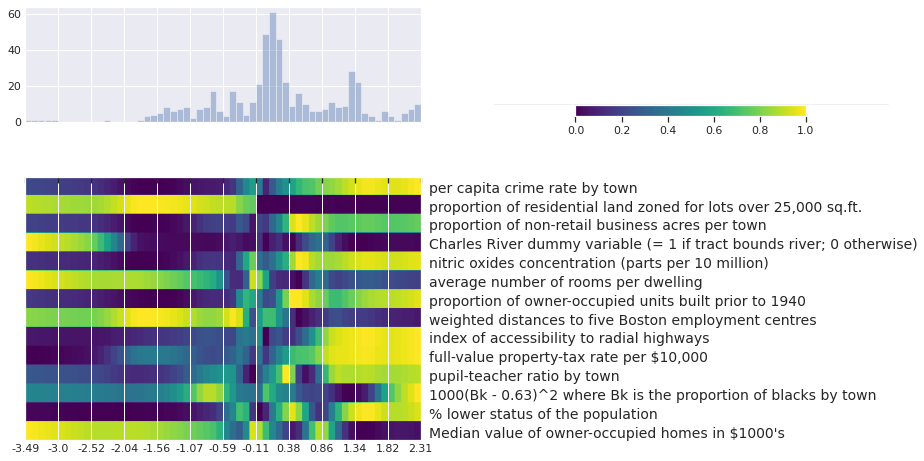

404/404 [==============================] - 1s 3ms/sample - loss: 0.0270 - val_loss: 0.0273
Epoch 652/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0265 - val_loss: 0.0270
Epoch 653/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0272 - val_loss: 0.0272
Epoch 654/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0266 - val_loss: 0.0272
Epoch 655/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0271 - val_loss: 0.0269
Epoch 656/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0264 - val_loss: 0.0269
Epoch 657/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0264 - val_loss: 0.0272
Epoch 658/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0265 - val_loss: 0.0273
Epoch 659/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0265 - val_loss: 0.0265
Epoch 660/1500
404/404 [=====================

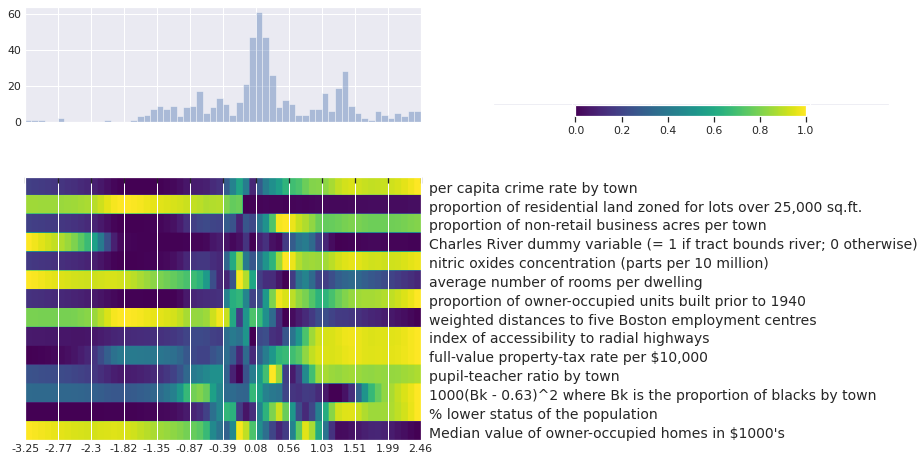

404/404 [==============================] - 1s 3ms/sample - loss: 0.0258 - val_loss: 0.0264
Epoch 702/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0262 - val_loss: 0.0267
Epoch 703/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0265 - val_loss: 0.0266
Epoch 704/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0265 - val_loss: 0.0266
Epoch 705/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0260 - val_loss: 0.0265
Epoch 706/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0260 - val_loss: 0.0257
Epoch 707/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0258 - val_loss: 0.0262
Epoch 708/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0259 - val_loss: 0.0270
Epoch 709/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0261 - val_loss: 0.0265
Epoch 710/1500
404/404 [=====================

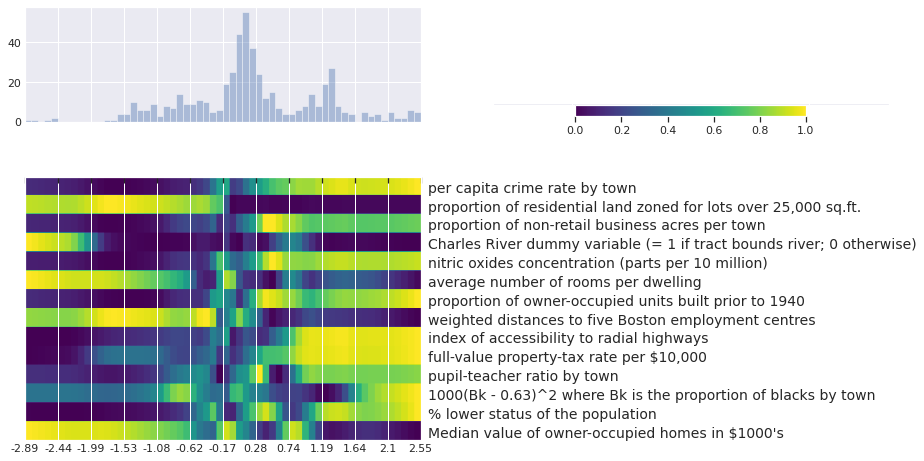

404/404 [==============================] - 1s 3ms/sample - loss: 0.0255 - val_loss: 0.0268
Epoch 752/1500
404/404 [==============================] - 0s 168us/sample - loss: 0.0259 - val_loss: 0.0267
Epoch 753/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0262 - val_loss: 0.0269
Epoch 754/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0259 - val_loss: 0.0265
Epoch 755/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0257 - val_loss: 0.0267
Epoch 756/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0261 - val_loss: 0.0266
Epoch 757/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0259 - val_loss: 0.0266
Epoch 758/1500
404/404 [==============================] - 0s 157us/sample - loss: 0.0256 - val_loss: 0.0258
Epoch 759/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0259 - val_loss: 0.0258
Epoch 760/1500
404/404 [=====================

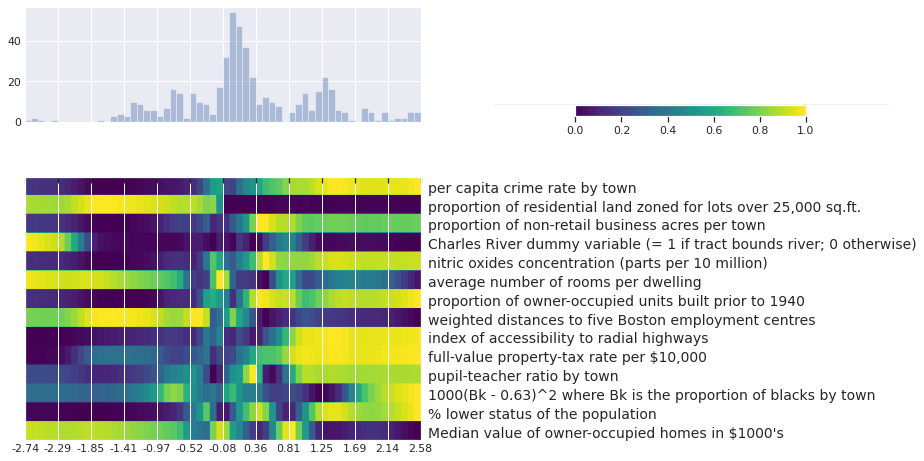

404/404 [==============================] - 1s 3ms/sample - loss: 0.0257 - val_loss: 0.0267
Epoch 802/1500
404/404 [==============================] - 0s 179us/sample - loss: 0.0254 - val_loss: 0.0266
Epoch 803/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0258 - val_loss: 0.0270
Epoch 804/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0254 - val_loss: 0.0269
Epoch 805/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0258 - val_loss: 0.0266
Epoch 806/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0250 - val_loss: 0.0265
Epoch 807/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0252 - val_loss: 0.0265
Epoch 808/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0252 - val_loss: 0.0265
Epoch 809/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0252 - val_loss: 0.0263
Epoch 810/1500
404/404 [=====================

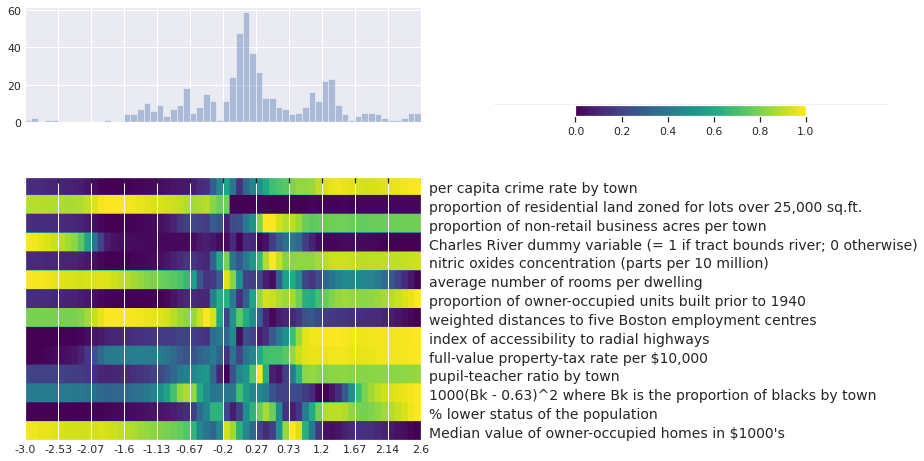

404/404 [==============================] - 1s 3ms/sample - loss: 0.0253 - val_loss: 0.0267
Epoch 852/1500
404/404 [==============================] - 0s 171us/sample - loss: 0.0251 - val_loss: 0.0267
Epoch 853/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0254 - val_loss: 0.0263
Epoch 854/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0250 - val_loss: 0.0262
Epoch 855/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0251 - val_loss: 0.0263
Epoch 856/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0255 - val_loss: 0.0265
Epoch 857/1500
404/404 [==============================] - 0s 157us/sample - loss: 0.0253 - val_loss: 0.0263
Epoch 858/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0249 - val_loss: 0.0264
Epoch 859/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0251 - val_loss: 0.0264
Epoch 860/1500
404/404 [=====================

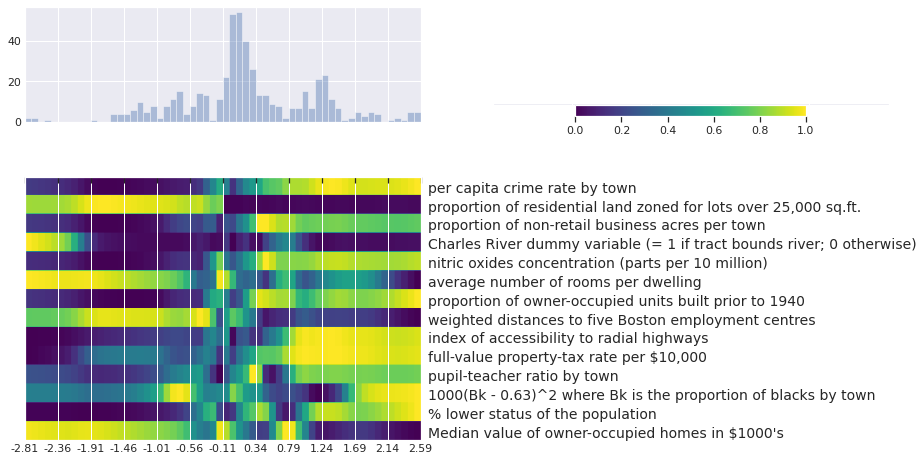

404/404 [==============================] - 1s 3ms/sample - loss: 0.0253 - val_loss: 0.0265
Epoch 902/1500
404/404 [==============================] - 0s 175us/sample - loss: 0.0252 - val_loss: 0.0266
Epoch 903/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0248 - val_loss: 0.0269
Epoch 904/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0249 - val_loss: 0.0263
Epoch 905/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0250 - val_loss: 0.0258
Epoch 906/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0249 - val_loss: 0.0258
Epoch 907/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0250 - val_loss: 0.0263
Epoch 908/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0244 - val_loss: 0.0267
Epoch 909/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0247 - val_loss: 0.0267
Epoch 910/1500
404/404 [=====================

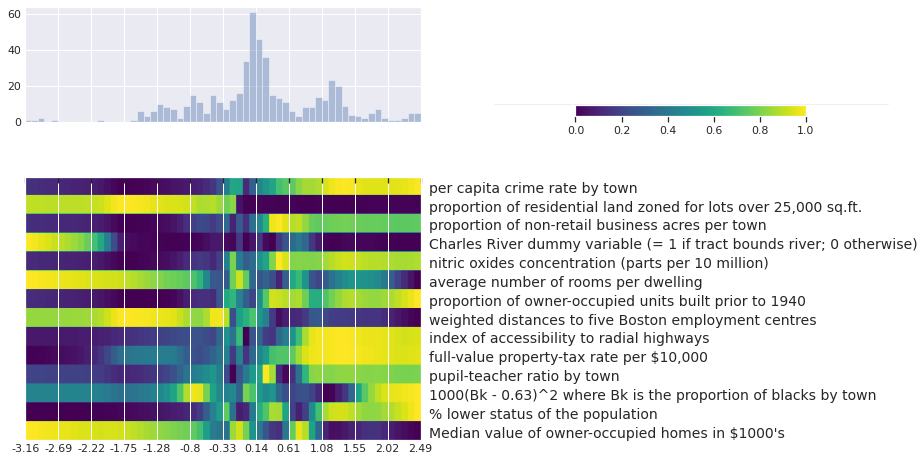

404/404 [==============================] - 1s 3ms/sample - loss: 0.0246 - val_loss: 0.0261
Epoch 952/1500
404/404 [==============================] - 0s 170us/sample - loss: 0.0247 - val_loss: 0.0257
Epoch 953/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0247 - val_loss: 0.0254
Epoch 954/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0243 - val_loss: 0.0255
Epoch 955/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0246 - val_loss: 0.0260
Epoch 956/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0250 - val_loss: 0.0263
Epoch 957/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0251 - val_loss: 0.0260
Epoch 958/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0245 - val_loss: 0.0256
Epoch 959/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0246 - val_loss: 0.0257
Epoch 960/1500
404/404 [=====================

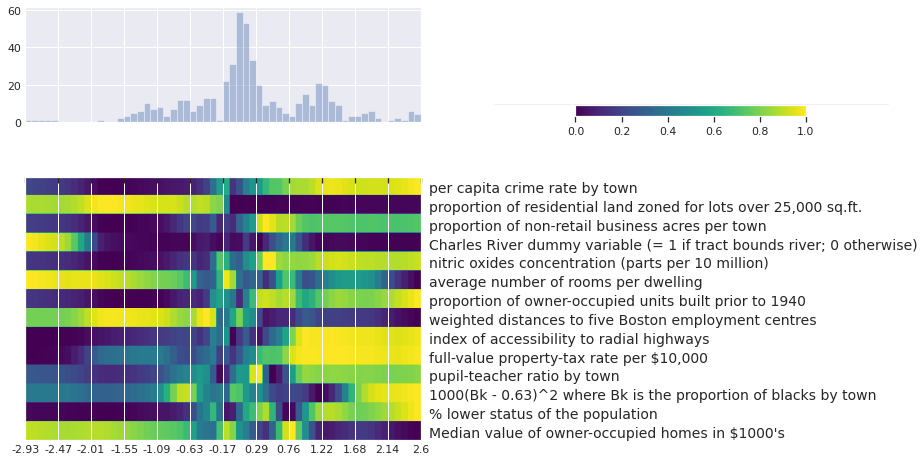

404/404 [==============================] - 1s 3ms/sample - loss: 0.0243 - val_loss: 0.0259
Epoch 1002/1500
404/404 [==============================] - 0s 168us/sample - loss: 0.0247 - val_loss: 0.0261
Epoch 1003/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0243 - val_loss: 0.0263
Epoch 1004/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0248 - val_loss: 0.0265
Epoch 1005/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0244 - val_loss: 0.0263
Epoch 1006/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0248 - val_loss: 0.0261
Epoch 1007/1500
128/404 [========>.....................] - ETA: 0s - loss: 0.0243
Epoch 01007: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
404/404 [==============================] - 0s 163us/sample - loss: 0.0245 - val_loss: 0.0261
Epoch 1008/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0242 - val_loss: 0.0261

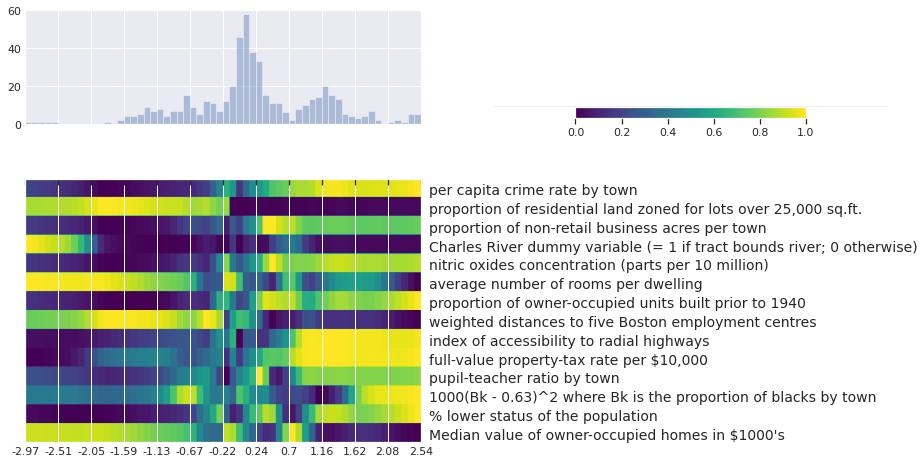

404/404 [==============================] - 1s 3ms/sample - loss: 0.0244 - val_loss: 0.0263
Epoch 1052/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0239 - val_loss: 0.0264
Epoch 1053/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0244 - val_loss: 0.0266
Epoch 1054/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0245 - val_loss: 0.0265
Epoch 1055/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0245 - val_loss: 0.0265
Epoch 1056/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0248 - val_loss: 0.0262
Epoch 1057/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0247 - val_loss: 0.0264
Epoch 1058/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0242 - val_loss: 0.0265
Epoch 1059/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0246 - val_loss: 0.0261
Epoch 1060/1500
404/404 [============

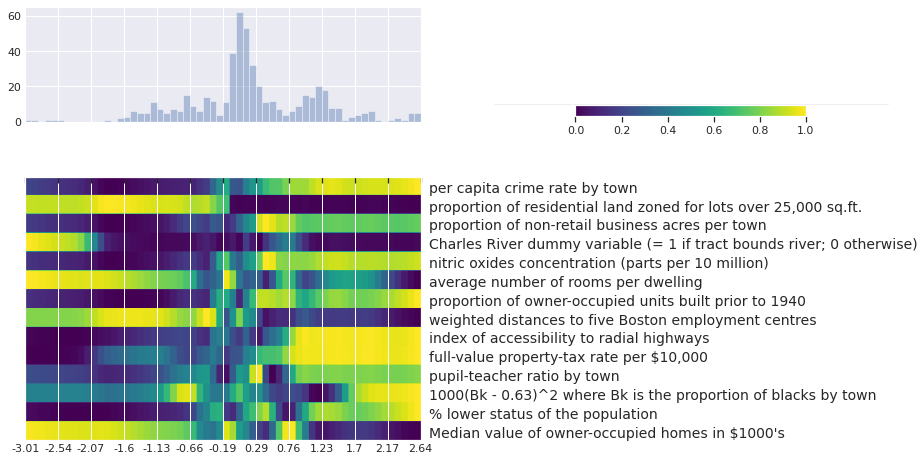

404/404 [==============================] - 1s 3ms/sample - loss: 0.0243 - val_loss: 0.0261
Epoch 1102/1500
404/404 [==============================] - 0s 182us/sample - loss: 0.0243 - val_loss: 0.0262
Epoch 1103/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0242 - val_loss: 0.0262
Epoch 1104/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0243 - val_loss: 0.0262
Epoch 1105/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0243 - val_loss: 0.0262
Epoch 1106/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0247 - val_loss: 0.0261
Epoch 1107/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0246 - val_loss: 0.0262
Epoch 1108/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0243 - val_loss: 0.0258
Epoch 1109/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0244 - val_loss: 0.0257
Epoch 1110/1500
404/404 [============

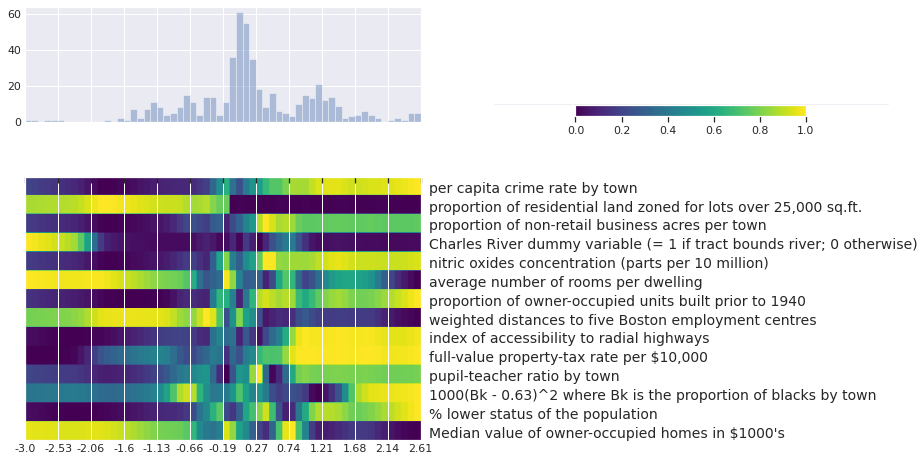

404/404 [==============================] - 1s 3ms/sample - loss: 0.0244 - val_loss: 0.0258
Epoch 1152/1500
404/404 [==============================] - 0s 174us/sample - loss: 0.0243 - val_loss: 0.0261
Epoch 1153/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0242 - val_loss: 0.0264
Epoch 1154/1500
404/404 [==============================] - 0s 158us/sample - loss: 0.0242 - val_loss: 0.0264
Epoch 1155/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0238 - val_loss: 0.0261
Epoch 1156/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0242 - val_loss: 0.0258
Epoch 1157/1500
128/404 [========>.....................] - ETA: 0s - loss: 0.0225
Epoch 01157: ReduceLROnPlateau reducing learning rate to 8.862938630045391e-05.
404/404 [==============================] - 0s 165us/sample - loss: 0.0240 - val_loss: 0.0256
Epoch 1158/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0241 - val_loss: 0.0255


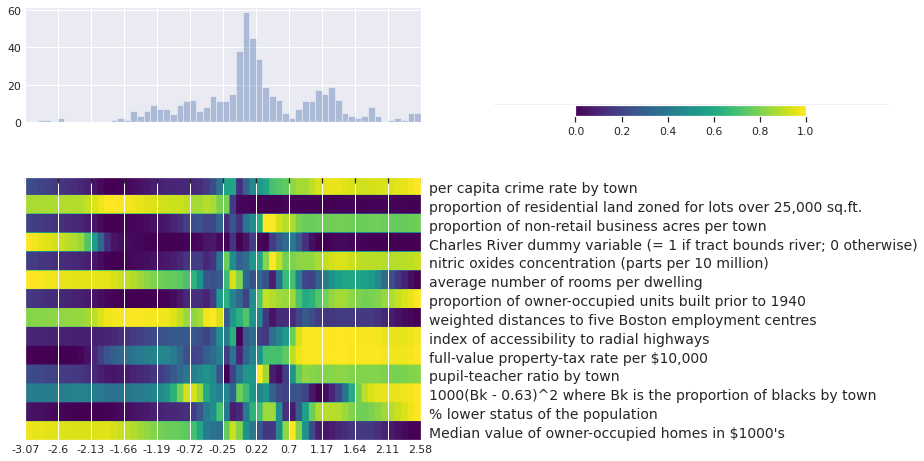

404/404 [==============================] - 1s 3ms/sample - loss: 0.0241 - val_loss: 0.0263
Epoch 1202/1500
404/404 [==============================] - 0s 170us/sample - loss: 0.0240 - val_loss: 0.0266
Epoch 1203/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0240 - val_loss: 0.0265
Epoch 1204/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0240 - val_loss: 0.0263
Epoch 1205/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0239 - val_loss: 0.0260
Epoch 1206/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0243 - val_loss: 0.0259
Epoch 1207/1500
404/404 [==============================] - 0s 171us/sample - loss: 0.0238 - val_loss: 0.0258
Epoch 1208/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0240 - val_loss: 0.0259
Epoch 1209/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0235 - val_loss: 0.0260
Epoch 1210/1500
404/404 [============

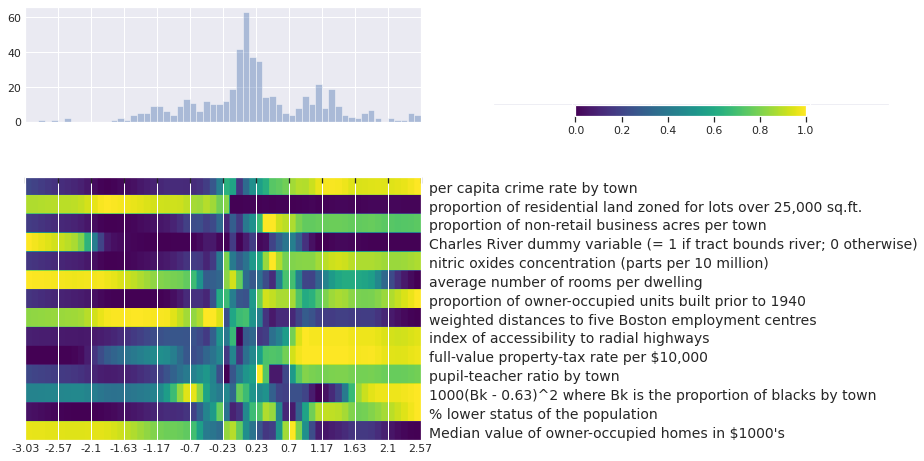

404/404 [==============================] - 1s 3ms/sample - loss: 0.0242 - val_loss: 0.0264
Epoch 1252/1500
404/404 [==============================] - 0s 168us/sample - loss: 0.0238 - val_loss: 0.0263
Epoch 1253/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0236 - val_loss: 0.0262
Epoch 1254/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0239 - val_loss: 0.0263
Epoch 1255/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0238 - val_loss: 0.0264
Epoch 1256/1500
404/404 [==============================] - 0s 167us/sample - loss: 0.0239 - val_loss: 0.0264
Epoch 1257/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0239 - val_loss: 0.0263
Epoch 1258/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0237 - val_loss: 0.0265
Epoch 1259/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0238 - val_loss: 0.0265
Epoch 1260/1500
404/404 [============

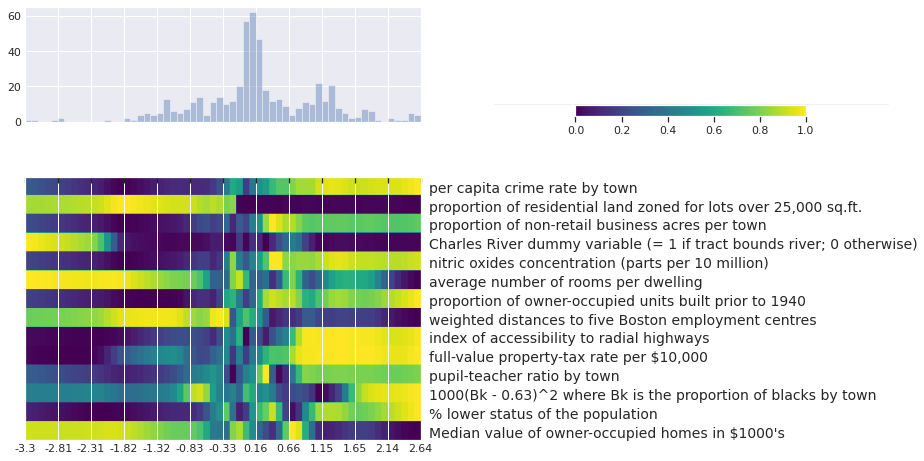

404/404 [==============================] - 1s 3ms/sample - loss: 0.0233 - val_loss: 0.0254
Epoch 1302/1500
404/404 [==============================] - 0s 171us/sample - loss: 0.0234 - val_loss: 0.0257
Epoch 1303/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0242 - val_loss: 0.0257
Epoch 1304/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0239 - val_loss: 0.0257
Epoch 1305/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0236 - val_loss: 0.0258
Epoch 1306/1500
404/404 [==============================] - 0s 166us/sample - loss: 0.0237 - val_loss: 0.0259
Epoch 1307/1500
128/404 [========>.....................] - ETA: 0s - loss: 0.0257
Epoch 01307: ReduceLROnPlateau reducing learning rate to 5.233476658759173e-05.
404/404 [==============================] - 0s 164us/sample - loss: 0.0239 - val_loss: 0.0260
Epoch 1308/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0235 - val_loss: 0.0261


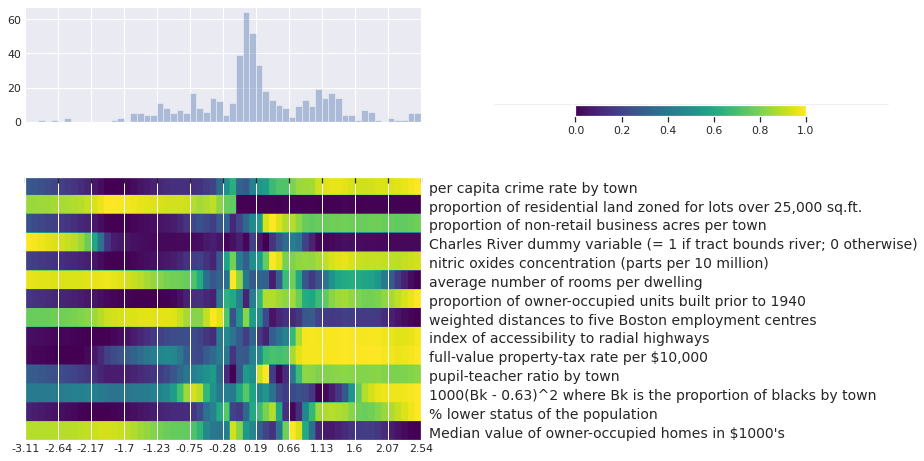

404/404 [==============================] - 1s 3ms/sample - loss: 0.0236 - val_loss: 0.0264
Epoch 1352/1500
404/404 [==============================] - 0s 170us/sample - loss: 0.0238 - val_loss: 0.0263
Epoch 1353/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0236 - val_loss: 0.0263
Epoch 1354/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0237 - val_loss: 0.0262
Epoch 1355/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0241 - val_loss: 0.0261
Epoch 1356/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0237 - val_loss: 0.0260
Epoch 1357/1500
404/404 [==============================] - 0s 165us/sample - loss: 0.0235 - val_loss: 0.0260
Epoch 1358/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0239 - val_loss: 0.0260
Epoch 1359/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0239 - val_loss: 0.0260
Epoch 1360/1500
404/404 [============

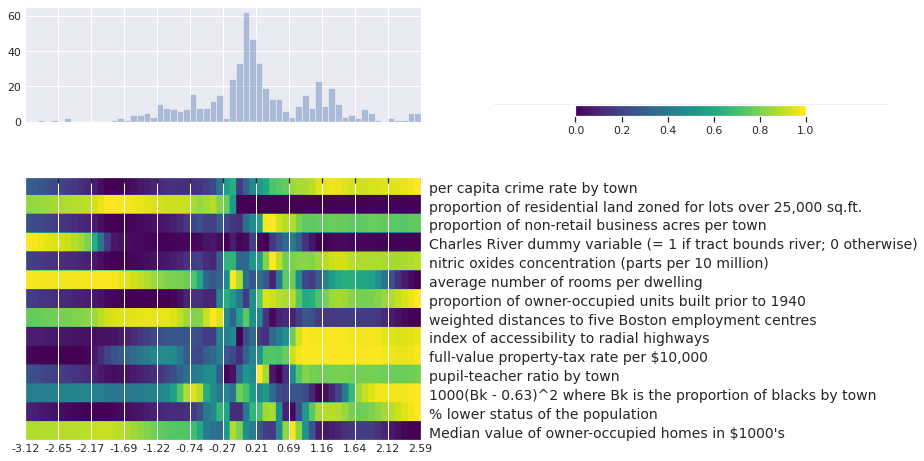

404/404 [==============================] - 1s 3ms/sample - loss: 0.0238 - val_loss: 0.0260
Epoch 1402/1500
404/404 [==============================] - 0s 172us/sample - loss: 0.0240 - val_loss: 0.0261
Epoch 1403/1500
404/404 [==============================] - 0s 164us/sample - loss: 0.0237 - val_loss: 0.0261
Epoch 1404/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0237 - val_loss: 0.0259
Epoch 1405/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0233 - val_loss: 0.0258
Epoch 1406/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0239 - val_loss: 0.0258
Epoch 1407/1500
404/404 [==============================] - 0s 160us/sample - loss: 0.0238 - val_loss: 0.0259
Epoch 1408/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0236 - val_loss: 0.0261
Epoch 1409/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0236 - val_loss: 0.0263
Epoch 1410/1500
404/404 [============

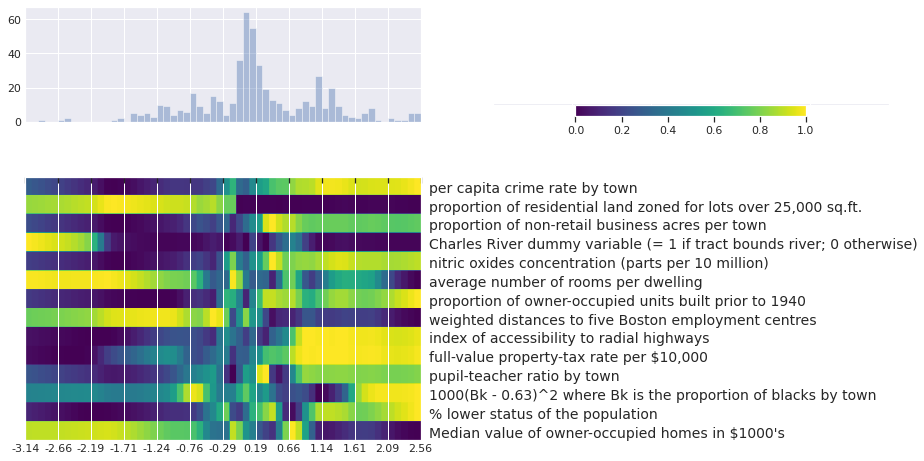

404/404 [==============================] - 1s 3ms/sample - loss: 0.0234 - val_loss: 0.0262
Epoch 1452/1500
404/404 [==============================] - 0s 169us/sample - loss: 0.0238 - val_loss: 0.0261
Epoch 1453/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0236 - val_loss: 0.0261
Epoch 1454/1500
404/404 [==============================] - 0s 162us/sample - loss: 0.0237 - val_loss: 0.0260
Epoch 1455/1500
404/404 [==============================] - 0s 163us/sample - loss: 0.0238 - val_loss: 0.0260
Epoch 1456/1500
404/404 [==============================] - 0s 159us/sample - loss: 0.0236 - val_loss: 0.0259
Epoch 1457/1500
128/404 [========>.....................] - ETA: 0s - loss: 0.0238
Epoch 01457: ReduceLROnPlateau reducing learning rate to 3.0903160222806036e-05.
404/404 [==============================] - 0s 164us/sample - loss: 0.0237 - val_loss: 0.0258
Epoch 1458/1500
404/404 [==============================] - 0s 161us/sample - loss: 0.0233 - val_loss: 0.0259

In [22]:
fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = vae.callback_list
    )

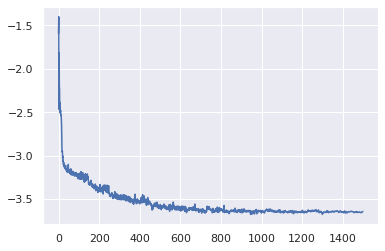

In [23]:
import matplotlib.pyplot as plt

plt.plot(np.log(fitted.history['val_loss']))

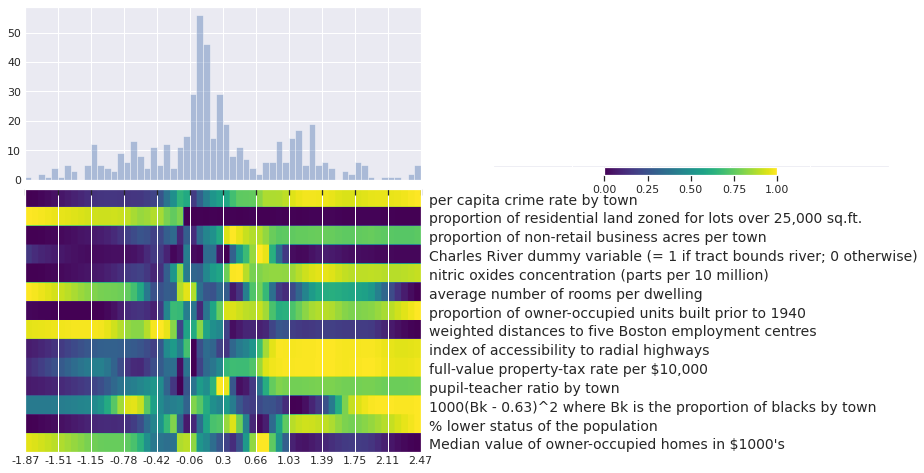

In [36]:
vnn.plot_types(encoder=vae.encoder,decoder=vae.decoder,data=qt, 
               **{'n_type': 60, 'each_hight' : 20, 
                                  'approx_width': 400, 
                                  'frac_width': 0.55, 
                                  'n_activity':  n_features,  
                                  'lowest_percentile': 1, 
                                  'highest_percentile' : 99, 
                                  'figsize': (10, 6),
                                  'cmap': 'viridis', 
                                  'n_xlabels':13, 
                                  'spacing': 0.001, 
                                  'hist_size': 0.4, 
                                  'scaler': True});

In [37]:
flag_1 = np.ones((qt.shape[0],1),dtype=qt.values.dtype)
data = np.concatenate((qt.values,flag_1),axis=-1)
encoded_data=pd.DataFrame(vae.encoder.predict(data))
encoded_data

,0
0,0.243017
1,-1.360007
2,0.830509
3,0.048554
4,1.467865
...,...
501,0.804459
502,0.052652
503,0.674644
504,-0.080393
